# Subtropical gyre analysis

In this notebook, we analyse the NAO-induced variations in subtropical gyre circulation. 

In [1]:
import numpy as np
import xarray as xr
import xesmf as xe
from eofs.xarray import Eof
from eofs.examples import example_data_path
import xgcm
from sklearn import preprocessing
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy import stats

import matplotlib.pyplot as plt
import cartopy.feature as cft
import cartopy.crs as ccrs
import cmocean as cm

import cosima_cookbook as cc

import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import cartopy.mpl.ticker as cticker

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = UserWarning)
warnings.simplefilter('ignore')

In [2]:
import dask
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38031,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:33281,Total threads: 4
Dashboard: /proxy/45683/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:38687,


In [3]:
start_time, end_time = '2071-01-01', '2100-12-31'
x_min, x_max = -100, 10
y_min, y_max = 10, 75
ρ0 = 1035

var_name = 'beta_v'
color_values = ['blue', 'lightblue', 'black', 'red', 'darkred']
expt_labels = ['-2$\sigma$', '-1$\sigma$', 'CTRL', '+1$\sigma$', '+2$\sigma$']

In [4]:
base_dir = '/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/NETCDF/'
dir_names = ['Monthly_mean_BVB_MOM6-SIS2_negativeNAO-2.0', 
             'Monthly_mean_BVB_MOM6-SIS2_negativeNAO-1.0', 
             'Monthly_mean_BVB_MOM6-SIS2_RYF_control', 
             'Monthly_mean_BVB_MOM6-SIS2_positiveNAO-1.0',
             'Monthly_mean_BVB_MOM6-SIS2_positiveNAO-2.0']

expt = ['mom6-om4-025-RYF-negativeNAO-2.0', 
        'mom6-om4-025-RYF-negativeNAO-1.0', 
        'mom6-om4-025-RYF-control', 
        'mom6-om4-025-RYF-positiveNAO-1.0',
        'mom6-om4-025-RYF-positiveNAO-2.0']

db = '/scratch/x77/db6174/mom6/archive/databases/cc_database_RYF_control.db'
session = cc.database.create_session(db)

In [5]:
x_min_subtropics, x_max_subtropics = -100, 0
y_min_subtropics, y_max_subtropics = 10, 52
x_min_subpolar, x_max_subpolar = -70, -8
y_min_subpolar, y_max_subpolar = 40, 67

## 1. Magnitudes of anomaly

First, we figure out how much the gyre strength is changing by doing a linear regression.

In [6]:
def psi_func_global(umo_2d):
    
    tx_trans_int_z = umo_2d.mean('time')

    ## 2-dimensional lat-lon grid
    geolon_t = geolon
    geolat_t = geolat

    ## Calculation of streamfunction from x-directed mass transport
    psi = -tx_trans_int_z.cumsum('yh')/(1e6*ρ0) # divide by 1e6 to convert m^3/s -> Sv
    psi_acc = np.nanmin(psi.sel(xq = slice(-69, -67), yh = slice(-80, -55)))
    psi_g = psi - psi_acc
    psi_g = psi_g.rename('psi')
    psi_g.attrs['long_name'] = 'Barotropic Streamfunction'
    psi_g.attrs['units'] = 'Sv'
    psi_g = psi_g.where(~np.isnan(tx_trans_int_z))
    
    ## Interpolating streamfunction to cell centre grid
    paths = []
    paths.append("/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup7_RCP45/output120/ocean/ocean.nc")
    data = xr.merge((psi_g, geolat_t))
    data.coords['xq'].attrs.update(axis='X')
    data.coords['xh'].attrs.update(axis='X',c_grid_axis_shift=0.5)
    g = xgcm.Grid(data, periodic=['X'])
    psi_g = g.interp(psi_g, 'X')
    psi_g = psi_g.rename('psi')
    
    return psi_g

def psi_func_subtropics(psi_g):
    return psi_g.sel(xh = slice(x_min_subtropics, x_max_subtropics)).sel(yh = slice(y_min_subtropics, y_max_subtropics))

def psi_func_subpolar(psi_g):
    return psi_g.sel(xh = slice(x_min_subpolar, x_max_subpolar)).sel(yh = slice(y_min_subpolar, y_max_subpolar))

In [7]:
umo_2d = cc.querying.getvar(expt[2], 'umo_2d', session, frequency = '1 monthly', start_time = start_time, 
                            end_time = end_time, chunks = {}).isel(xq = slice(1, None)).sel(time = slice(start_time, end_time))
vmo_2d = cc.querying.getvar(expt[2], 'vmo_2d', session, frequency = '1 monthly', start_time = start_time, 
                            end_time = end_time, chunks = {}).isel(yq = slice(1, None)).sel(time = slice(start_time, end_time))

grid_data = xr.merge((umo_2d, vmo_2d))
grid = xgcm.Grid(grid_data, coords={'X': {'center': 'xh', 'right': 'xq'}, 'Y': {'center': 'yh', 'right': 'yq'}}, periodic=['X'])
vmo_2d_itp = grid.interp(vmo_2d, 'X', boundary = 'fill')

area_bu = cc.querying.getvar(expt[2], 'areacello_bu', session, frequency = 'static', n = 1).isel(xq = slice(1, None)).isel(yq = slice(1, None))
#area_bu = area_bu * (vmo_2d_itp[0]/vmo_2d_itp[0])
area_bu_NA = area_bu.sel(xq = slice(x_min, x_max)).sel(yq = slice(y_min, y_max))

In [8]:
geolon = cc.querying.getvar(expt[2], 'geolon', session, frequency = 'static', n = 1)
geolat = cc.querying.getvar(expt[2], 'geolat', session, frequency = 'static', n = 1)

In [9]:
for i in range(5):
    umo_2d = umo_2d = cc.querying.getvar(expt[i], 'umo_2d', session, frequency = '1 monthly', start_time = start_time, 
                            end_time = end_time, chunks = {}).isel(xq = slice(1, None)).sel(time = slice(start_time, end_time))
    psi_g = psi_func_global(umo_2d)
    psi_subtropics_expt = psi_func_subtropics(psi_g)
    psi_subpolar_expt = psi_func_subpolar(psi_g)

    if(i == 0):
        psi_subtropics = psi_subtropics_expt
        psi_subpolar = psi_subpolar_expt
    else:
        psi_subtropics = xr.concat([psi_subtropics, psi_subtropics_expt], dim = 'time')
        psi_subpolar = xr.concat([psi_subpolar, psi_subpolar_expt], dim = 'time')

In [10]:
psi_subtropics = psi_subtropics.assign_coords(time = [-2, -1, 0, 1, 2]).load()
psi_subpolar   = psi_subpolar.  assign_coords(time = [-2, -1, 0, 1, 2]).load()

## 2. Find anomalies in terms in barotropic vorticity budget

In [11]:
def da_north_atlantic_mask_vmo(da):
    ht = cc.querying.getvar(expt[2], 'deptho', session, n = -1)
    ht = grid.interp(ht, 'X', boundary = 'fill')
    ht = grid.interp(ht, 'Y', boundary = 'fill')
    land_mask = ~ht.isnull()
    
    ## create masks out of the above chunks
    south_map = (land_mask.where(land_mask.yq < -34)).fillna(0)
    indo_map1 = (land_mask.where(land_mask.yq < 9).where(land_mask.yq > -34).where(land_mask.xq > -280).where(land_mask.xq < -65)).fillna(0)
    indo_map2 = (land_mask.where(land_mask.yq < 15).where(land_mask.yq > 9).where(land_mask.xq > -280).where(land_mask.xq < -83.7)).fillna(0)
    indo_map3 = (land_mask.where(land_mask.yq < 17).where(land_mask.yq > 15).where(land_mask.xq > -280).where(land_mask.xq < -93.3)).fillna(0)
    indo_map4 = (land_mask.where(land_mask.yq < 85).where(land_mask.yq > 17).where(land_mask.xq > -280).where(land_mask.xq < -99)).fillna(0)
    indo_map5 = (land_mask.where(land_mask.yq < 30.5).where(land_mask.yq > -34).where(land_mask.xq > 25).where(land_mask.xq < 80)).fillna(0)
    
    indo_sector_map = indo_map1 + indo_map2 + indo_map3 + indo_map4 + indo_map5 + south_map
    indo_sector_mask = indo_sector_map.where(indo_sector_map>0)
    
    atlantic_sector_map = (indo_sector_mask * 0).fillna(1) * land_mask
    atlantic_sector_map = atlantic_sector_map + south_map
    atlantic_sector_mask = atlantic_sector_map.where(atlantic_sector_map > 0)
    
    north_atlantic_sector_mask = atlantic_sector_mask.sel(xq = slice(x_min, x_max)).sel(yq = slice(y_min, y_max))
    return da * north_atlantic_sector_mask

In [12]:
umo_2d = cc.querying.getvar(expt[2], 'umo_2d', session, frequency = '1 monthly', start_time = start_time, 
                            end_time = end_time, chunks = {}).isel(xq = slice(1, None)).sel(time = slice(start_time, end_time))
vmo_2d = cc.querying.getvar(expt[2], 'vmo_2d', session, frequency = '1 monthly', start_time = start_time, 
                            end_time = end_time, chunks = {}).isel(yq = slice(1, None)).sel(time = slice(start_time, end_time))

grid_data = xr.merge((umo_2d, vmo_2d))
grid = xgcm.Grid(grid_data, coords={'X': {'center': 'xh', 'right': 'xq'}, 'Y': {'center': 'yh', 'right': 'yq'}}, periodic=['X'])

vmo_2d_itp = grid.interp(vmo_2d, 'X', boundary = 'fill')
vmo_2d_NA = da_north_atlantic_mask_vmo(vmo_2d_itp)

In [13]:
Ψ_NA = vmo_2d_NA.cumsum('xq')/(1e6 * ρ0)
Ψ_NA_tmean = Ψ_NA.mean('time').load()
area_bu = cc.querying.getvar(expt[2], 'areacello_bu', session, frequency = 'static', n = 1)
area_bu_NA = da_north_atlantic_mask_vmo(area_bu)
area_bu_NA = area_bu_NA.where(~np.isnan(Ψ_NA_tmean))

In [14]:
R_earth = 6.378e6
Ω = 7.2921e-5

dyCv = cc.querying.getvar(expt[2], 'dyCv', session, frequency = 'static', n = 1).mean('xh')
geolat_c = cc.querying.getvar(expt[2], 'geolat_c', session, frequency = 'static', n = 1)
geolat_c = geolat_c.where(~np.isnan(Ψ_NA_tmean))

Text(0.5, 1.0, 'Subtropical gyre area integration')

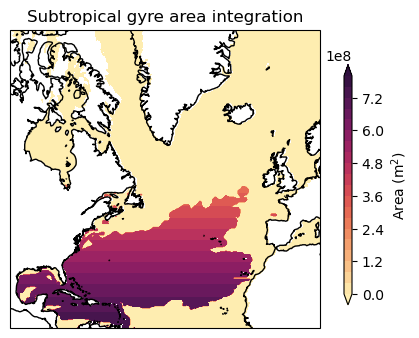

In [15]:
cutoff_contour = 0 ## in Sverdrups

projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 4), subplot_kw = {'projection': projection})

mask_Ψ = xr.where(Ψ_NA_tmean >= cutoff_contour, 1, 0)
mask_Ψ = xr.where(mask_Ψ.yq <=52, mask_Ψ, 0)
area_subtropics = area_bu_NA * mask_Ψ
p1 = axes.contourf(area_subtropics.xq, area_subtropics.yq, area_subtropics, levels = np.linspace(0, 8e8, 21), 
            cmap = cm.cm.matter, transform = ccrs.PlateCarree(), extend = 'both', color = 'black')

cax = plt.axes([0.96, 0.18, 0.02, 0.6])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Area (m$^2$)', fontsize = 10)

axes.set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
axes.coastlines(resolution = '50m')
axes.set_title('Subtropical gyre area integration')

In [16]:
## One edge case remains, where the function encounters 3 alternating values, like 1, 0, 1.
## Another edge case is when the cutoff contour is close to zero.

def mask_interpolation_transect(Ψ, y_sel, zero_precedes_one, one_precedes_zero, cutoff_contour, old_mask, gyre_type):

    ## This is the original mask
    new_mask = old_mask.copy(deep = True)

    ## We create a streamfunction transect with values greater/smaller than the cutoff transport
    if(gyre_type == 'subtropical'):
        Ψ_cutoff = Ψ.where(Ψ >=cutoff_contour).dropna('xq').load()
    elif(gyre_type == 'subpolar'):
        Ψ_cutoff = Ψ.where(Ψ <=cutoff_contour).dropna('xq').load()

    ## Checking if there are any values to interpolate (true for latitudes where the streamfunction is weaker than the cutoff for all longitudes)
    if(Ψ_cutoff.shape[0] == 0):  
        return old_mask, old_mask
    
    if(zero_precedes_one.shape[0] > 0):
        for i in zero_precedes_one:
            x_west = Ψ.xq[i]
            x_east = Ψ.xq[i+1]
            Ψ_east = Ψ.sel(xq = x_east, method = 'nearest').values
            Ψ_west = Ψ.sel(xq = x_west, method = 'nearest').values

            if (np.isnan(Ψ_west.item()) or np.isnan(Ψ_east.item())):
                continue

            slope = (Ψ_east - Ψ_west)/(x_east - x_west)
            x_mid = x_east - (Ψ_east - cutoff_contour)/slope
            mask_fraction = (x_east - x_mid)/(x_east - x_west)
            new_mask = xr.where(old_mask.xq == x_east, mask_fraction, new_mask)

    if(one_precedes_zero.shape[0] > 0):
        for i in one_precedes_zero:
            x_west = Ψ.xq[i]
            x_east = Ψ.xq[i+1]
            Ψ_east = Ψ.sel(xq = x_east, method = 'nearest').values
            Ψ_west = Ψ.sel(xq = x_west, method = 'nearest').values

            if (np.isnan(Ψ_west.item()) or np.isnan(Ψ_east.item())):
                continue

            slope = (Ψ_east - Ψ_west)/(x_east - x_west)
            x_mid = x_east - (Ψ_east - cutoff_contour)/slope
            mask_fraction = 1 - (x_east - x_mid)/(x_east - x_west)
            new_mask = xr.where(old_mask.xq == x_east, mask_fraction, new_mask)
        
    return old_mask, new_mask

def mask_with_interpolation(Ψ, old_mask_total, cutoff_contour, gyre_type, y_min_bound = None, y_max_bound = None):
           
    for y_sel in Ψ.yq.sel(yq = slice(y_min_bound, y_max_bound)).values:
        Ψ_ysel = Ψ.sel(yq = y_sel, method = 'nearest')
        old_mask = old_mask_total.sel(yq = y_sel, method = 'nearest')

        zero_precedes_one = np.where((old_mask.values[:-1] == 0) & (old_mask.values[1:] == 1))[0]
        one_precedes_zero = np.where((old_mask.values[:-1] == 1) & (old_mask.values[1:] == 0))[0]
        old_mask, new_mask = mask_interpolation_transect(Ψ_ysel, y_sel, zero_precedes_one, one_precedes_zero, cutoff_contour, old_mask, gyre_type)

        if(y_sel == Ψ.yq[0].item()):
            new_mask_total = new_mask
        else:
            new_mask_total = xr.concat([new_mask_total, new_mask], dim = 'yq')

    return new_mask_total

In [17]:
area_bu = cc.querying.getvar(expt[2], 'areacello_bu', session, frequency = 'static', n = 1)
area_bu = da_north_atlantic_mask_vmo(area_bu)
area_bu = area_bu.where(~np.isnan(vmo_2d_itp.isel(time = 0))).fillna(0)

def gyre_percentile_subtropics(expt_val, quantile, time_mean = True):
    umo_2d = cc.querying.getvar(expt_val, 'umo_2d', session, frequency = '1 monthly', start_time = start_time, 
                            end_time = end_time, chunks = {}).isel(xq = slice(1, None)).sel(time = slice(start_time, end_time))
    vmo_2d = cc.querying.getvar(expt_val, 'vmo_2d', session, frequency = '1 monthly', start_time = start_time, 
                                end_time = end_time, chunks = {}).isel(yq = slice(1, None)).sel(time = slice(start_time, end_time))
    
    grid_data = xr.merge((umo_2d, vmo_2d))
    grid = xgcm.Grid(grid_data, coords={'X': {'center': 'xh', 'right': 'xq'}, 'Y': {'center': 'yh', 'right': 'yq'}}, periodic=['X'])
    
    vmo_2d_itp = grid.interp(vmo_2d, 'X', boundary = 'fill')
    vmo_2d_NA = da_north_atlantic_mask_vmo(vmo_2d_itp)
    Ψ_NA = vmo_2d_NA.cumsum('xq')/(1e6 * ρ0)
    if(time_mean == True):
        Ψ_NA_tmean = Ψ_NA.mean('time')
    else:
        Ψ_NA_tmean = Ψ_NA.coarsen(time = 12).mean()
    Ψ_NA_tmean = Ψ_NA_tmean.chunk(chunks = {'xq':-1, 'yq':-1})
    Ψ_NA_tmean = Ψ_NA_tmean.sel(xq = slice(x_min_subtropics, x_max_subtropics)).sel(yq = slice(y_min_subtropics, y_max_subtropics))
    Ψ_gyre = Ψ_NA_tmean.weighted(area_bu).quantile(quantile, dim = {"yq", "xq"})

    return Ψ_NA_tmean, Ψ_gyre

In [18]:
def gyre_percentile_subtropics_all_years(expt_val, quantile, time_mean = True):
    start_time = '2001-01-01'
    end_time = '2100-12-31'
    umo_2d = cc.querying.getvar(expt_val, 'umo_2d', session, frequency = '1 monthly', start_time = start_time, 
                            end_time = end_time, chunks = {}).isel(xq = slice(1, None)).sel(time = slice(start_time, end_time))
    vmo_2d = cc.querying.getvar(expt_val, 'vmo_2d', session, frequency = '1 monthly', start_time = start_time, 
                                end_time = end_time, chunks = {}).isel(yq = slice(1, None)).sel(time = slice(start_time, end_time))
    
    grid_data = xr.merge((umo_2d, vmo_2d))
    grid = xgcm.Grid(grid_data, coords={'X': {'center': 'xh', 'right': 'xq'}, 'Y': {'center': 'yh', 'right': 'yq'}}, periodic=['X'])
    
    vmo_2d_itp = grid.interp(vmo_2d, 'X', boundary = 'fill')
    vmo_2d_NA = da_north_atlantic_mask_vmo(vmo_2d_itp)
    Ψ_NA = vmo_2d_NA.cumsum('xq')/(1e6 * ρ0)
    if(time_mean == True):
        Ψ_NA_tmean = Ψ_NA.mean('time')
    else:
        Ψ_NA_tmean = Ψ_NA.coarsen(time = 12).mean()
    Ψ_NA_tmean = Ψ_NA_tmean.chunk(chunks = {'xq':-1, 'yq':-1})
    Ψ_NA_tmean = Ψ_NA_tmean.sel(xq = slice(x_min_subtropics, x_max_subtropics)).sel(yq = slice(y_min_subtropics, y_max_subtropics))
    Ψ_gyre = Ψ_NA_tmean.weighted(area_bu).quantile(quantile, dim = {"yq", "xq"})

    return Ψ_NA_tmean, Ψ_gyre

In [19]:
mask_Ψ.load()
cutoff_whole = 0
mask_Ψ_improved = mask_with_interpolation(Ψ_NA_tmean, mask_Ψ, cutoff_whole, gyre_type = 'subtropical')

In [20]:
var_list = ['beta_v', 'BPT', 'curl_NL', 'curl_taus', 'curl_taub', 'curl_diff', 'mass_flux', 'curl_dudt', 'eta_dt']
expt_labels = ['-2$\sigma$', '-1$\sigma$', 'CTRL', '+1$\sigma$', '+2$\sigma$']
color_values = ['blue', 'lightblue', 'black', 'red', 'darkred']

In [21]:
def find_last_one(arr):
    return np.array([np.max(np.where(row!=0)) if np.any(row!=0) else -1 for row in arr])
    
def masks_separation_gyre_strength(mask_western_gyre_improved, mask_Ψ_improved):

    data_np = mask_western_gyre_improved.values
    last_ones = find_last_one(mask_western_gyre_improved.values)
    updated_data_np = data_np.copy()
    updated_data_np2 = data_np.copy()
    for i, last_idx in enumerate(last_ones):
        if last_idx == -1:  # If there is at least one '1' in the row
            updated_data_np2[i, :] = 1
        else:
            updated_data_np[i, :last_idx] = 1
            updated_data_np2[i, :last_idx] = 0
            updated_data_np2[i, last_idx] = 1 - data_np[i, last_idx]
            updated_data_np2[i, last_idx + 1:] = 1

    mask_GS_west = xr.DataArray(updated_data_np, dims = ["yq", "xq"], coords = 
                                [mask_western_gyre_improved.yq, mask_western_gyre_improved.xq])
    mask_GS_east = xr.DataArray(updated_data_np2, dims = ["yq", "xq"], coords = 
                                [mask_western_gyre_improved.yq, mask_western_gyre_improved.xq])

    mask_GS_west = xr.where((mask_Ψ_improved + mask_GS_west) > 1, mask_Ψ_improved, 0)
    mask_GS_east = mask_Ψ_improved - mask_GS_west

    return mask_GS_west, mask_GS_east

In [22]:
expt_labels = ['-2$\sigma$', '-1$\sigma$', 'CTRL', '+1$\sigma$', '+2$\sigma$']
color_values = ['blue', 'lightblue', 'black', 'red', 'darkred']
#var_list_subset = ['BPT', 'curl_NL', 'curl_taus', 'curl_taub', 'curl_diff', 'mass_flux', 'curl_dudt', 'eta_dt']
gyre_strength_comparison = np.zeros(5)

array_western = np.zeros((5, 10))
array_eastern = np.zeros((5, 10))

for j, expt_name in enumerate(dir_names):
    Ψ_NA_tmean, Ψ_gyre_strength = gyre_percentile_subtropics(expt[j], 0.95)
    Ψ_NA_tmean.load()
    Ψ_gyre_strength.load()
    mask_Ψ = xr.where(Ψ_NA_tmean >= cutoff_contour, 1, 0)
    mask_Ψ = xr.where(mask_Ψ.yq <=52, mask_Ψ, 0).load()
    mask_Ψ_improved = mask_with_interpolation(Ψ_NA_tmean, mask_Ψ, cutoff_contour, gyre_type = 'subtropical').load()
    mask_western_gyre = xr.where(Ψ_NA_tmean >=Ψ_gyre_strength, 1, 0).load()
    mask_western_gyre_improved = mask_with_interpolation(Ψ_NA_tmean, mask_western_gyre, Ψ_gyre_strength, gyre_type = 'subtropical').load()
    mask_interior_improved = (mask_Ψ_improved - mask_western_gyre_improved)
    western_mask_subtropics, eastern_mask_subtropics = masks_separation_gyre_strength(mask_western_gyre_improved, mask_Ψ_improved)
    gyre_strength_comparison[j] = Ψ_gyre_strength
    vort_BPT = xr.open_dataset(base_dir + dir_names[j] + '/bvb.nc').BPT.sel(time = slice(start_time, end_time))

    β = 2 * Ω * np.cos(geolat_c * np.pi /180.)/R_earth
    β = (xr.where(western_mask_subtropics == 0, np.nan, 1) * β).mean('xq')

    bvb_ds = xr.open_dataset(base_dir + dir_names[j] + '/bvb.nc').sel(time = slice(start_time, end_time))
    temp_western = np.zeros(9)
    temp_eastern = np.zeros(9)
    print(j)
    for i, var_name in enumerate(var_list):
        var = bvb_ds[var_name]
        var = xr.where(np.isnan(vort_BPT.isel(time = 0)), np.nan, var)
        var = (var * eastern_mask_subtropics * area_bu_NA).sum('xq').sum('yq').mean('time')
        var = var/(β * dyCv).sum('yq')/1e6
        temp_eastern[i] = var.values
    
        var = bvb_ds[var_name]
        var = xr.where(np.isnan(vort_BPT.isel(time = 0)), np.nan, var)
        var = (var * western_mask_subtropics * area_bu_NA).sum('xq').sum('yq').mean('time')
        var = var/(β * dyCv).sum('yq')/1e6
        temp_western[i] = var.values
        
    array_western[j, 0:9] = temp_western
    array_eastern[j, 0:9] = temp_eastern
    array_western[j, 9] = np.sign(np.sum(temp_western[1:])) * Ψ_gyre_strength.values - np.sum(temp_western[1:])
    array_eastern[j, 9] = np.sign(np.sum(temp_eastern[1:])) * Ψ_gyre_strength.values - np.sum(temp_eastern[1:])

0
1
2
3
4


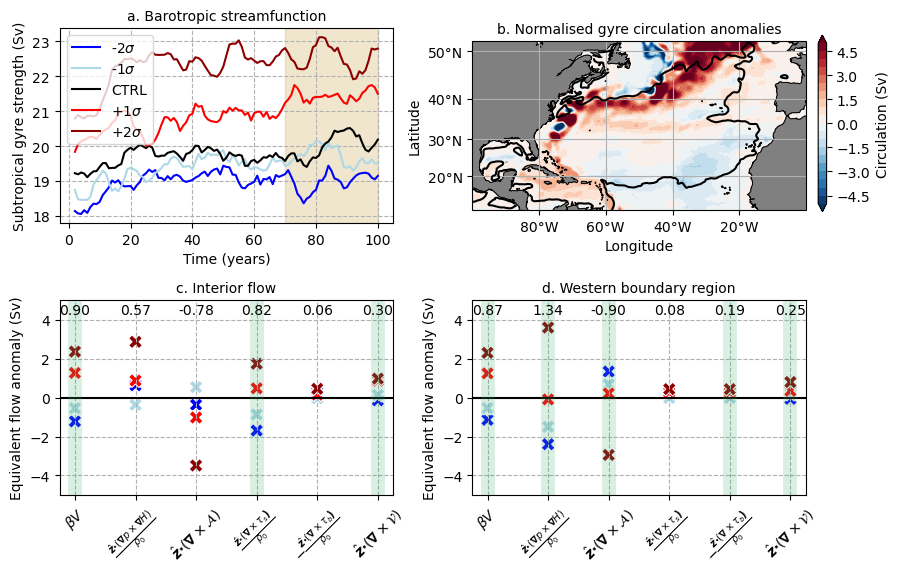

In [23]:
fig = plt.figure()
fig.set_figheight(4.2 * 1.4)
fig.set_figwidth(6 * 1.4)

ax1 = plt.subplot2grid(shape = (2, 2), loc = (0, 0), rowspan = 1, colspan = 1)

## A. Gyre strength

for j, expt_name in enumerate(dir_names):
    Ψ_NA_tmean, Ψ_gyre_strength = gyre_percentile_subtropics_all_years(expt[j], 0.95, time_mean = False)
    ax1.plot(np.linspace(1, 100, 100), Ψ_gyre_strength.rolling(time = 5, min_periods = 2).mean().values, color = color_values[j], 
                 label = expt_labels[j])
ax1.set_title('a. Barotropic streamfunction', fontsize = 10)
ax1.set_ylabel('Subtropical gyre strength (Sv)')
ax1.set_xlabel('Time (years)')
ax1.legend()
ax1.axvspan(xmin = 70, xmax = 100, alpha = 0.2, color = 'darkgoldenrod')
ax1.grid(True, ls = '--')
    
# Define significance threshold
p_value_threshold = 0.1

# Define custom colors for each experiment
custom_palette = {
    expt_labels[0]: color_values[0],
    expt_labels[1]: color_values[1],
    expt_labels[2]: color_values[2],
    expt_labels[3]: color_values[3],
    expt_labels[4]: color_values[4],
}

## B. Anomalies in gyre circulation

projection = ccrs.Mercator(central_longitude = (x_max_subtropics + x_min_subtropics)/2, min_latitude = y_min_subtropics, max_latitude = y_max_subtropics)

ax1 = plt.subplot2grid(shape = (2, 2), loc = (0, 1), rowspan = 1, colspan = 1, projection = projection)

my_yticks = [20, 30, 40, 50]
my_xticks = [-80, -60, -40, -20]

land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor='gray', linewidth = 0.5)
ax1.coastlines(resolution = '50m')
ax1.add_feature(land_50m)
gl = ax1.gridlines(draw_labels = False)

a = -psi_subtropics.time
b = psi_subtropics
d = ((a-a.mean('time'))*(b-b.mean('time'))/a.std('time')).mean('time')

p1 = ax1.contourf(psi_subtropics.xh, psi_subtropics.yh, -d, levels = np.linspace(-5, 5, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')
ax1.contour(psi_subtropics.xh, psi_subtropics.yh, psi_subtropics[2], levels = [0], cmap = 'Greys_r', 
                transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.98, 0.63, 0.01, 0.3])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Circulation (Sv)', fontsize = 10)

ax1.set_title('b. Normalised gyre circulation anomalies', fontsize = 10)

ax1.set_yticks(my_yticks, crs = ccrs.PlateCarree())
ax1.yaxis.set_major_formatter(cticker.LatitudeFormatter())
ax1.set_ylabel('Latitude')

ax1.set_xticks(my_xticks, crs = ccrs.PlateCarree())
ax1.xaxis.set_major_formatter(cticker.LongitudeFormatter())
ax1.set_xlabel('Longitude')

## D. Gyre's western boundary

ax1 = plt.subplot2grid(shape = (2, 2), loc = (1, 1), rowspan = 1, colspan = 1)

array_western_difference = array_western - array_western[2, :]

WBC_subtropics = {
    'Experiment': expt_labels,
    r'$\beta V$': list(array_western[:, 0]),
    r'$\frac{\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} p \times \boldsymbol{\nabla} H)}{\rho_0}$': list(array_western[:, 1]),
    r'$\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} \times \boldsymbol{\mathcal{A}})$': list(array_western[:, 2]),
    r'$\frac{\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} \times \boldsymbol{\tau_s)}}{\rho_0}$': list(array_western[:, 3]),
    r'$-\frac{\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} \times \boldsymbol{\tau_b)}}{\rho_0}$': list(array_western[:, 4]),
    r'$\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} \times \boldsymbol{\mathcal{V}})$': list(array_western[:, 5])
}

WBC_subtropics_difference = {
    'Experiment': expt_labels,
    r'$\beta V$': list(array_western_difference[:, 0]),
    r'$\frac{\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} p \times \boldsymbol{\nabla} H)}{\rho_0}$': list(array_western_difference[:, 1]),
    r'$\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} \times \boldsymbol{\mathcal{A}})$': list(array_western_difference[:, 2]),
    r'$\frac{\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} \times \boldsymbol{\tau_s)}}{\rho_0}$': list(array_western_difference[:, 3]),
    r'$-\frac{\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} \times \boldsymbol{\tau_b)}}{\rho_0}$': list(array_western_difference[:, 3]),
    r'$\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} \times \boldsymbol{\mathcal{V}})$': list(array_western_difference[:, 4])
}

# Convert to DataFrame
WBC_subtropics = pd.DataFrame(WBC_subtropics)
WBC_subtropics_difference = pd.DataFrame(WBC_subtropics_difference)
WBC_subtropics_difference = WBC_subtropics_difference[WBC_subtropics_difference["Experiment"] != "CTRL"]

# Reshape the data for easier plotting with scatter points
WBC_melted = pd.melt(WBC_subtropics_difference, id_vars = ['Experiment'], var_name = 'Vorticity term', value_name = 'Equivalent flow (Sv)')

# Assign numerical indices to experiments
experiment_indices = np.array([-2, -1, 0, 1, 2])

# Create the scatter plot with points instead of lines
sns.scatterplot(data = WBC_melted, x = 'Vorticity term', y = 'Equivalent flow (Sv)', hue = 'Experiment', palette=custom_palette, 
                style = 'Experiment', s = 100, markers=['X']*5, color = color_values, ax = ax1, legend = False)
ax1.set_title('d. Western boundary region', fontsize = 10)
ax1.set_xlabel('')
ax1.set_ylabel('Equivalent flow anomaly (Sv)')
ax1.grid(True, ls = '--')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45)
ax1.axhline(0, color = 'black')
ax1.set_ylim([-5, 5])

# Initialize a dictionary to store slopes and p-values
results = {}

# Perform linear regression for each variable and calculate p-value
for j, variable in enumerate(WBC_melted['Vorticity term'].unique()):
    y_values = WBC_subtropics[variable].values
    x_values = sm.add_constant(experiment_indices)
    
    # Fit the linear model
    model = sm.OLS(y_values, x_values).fit()
    
    # Store the slope and p-value
    slope = model.params[1]
    p_value = model.pvalues[1]
    results[variable] = (slope, p_value)
    if p_value < p_value_threshold:
        ax1.axvline(j, color = 'mediumseagreen', alpha = 0.2, linewidth = 10)
    #elif p_value < p_value_threshold * 2:
    #    ax1.axvline(j, color = 'darkgoldenrod', alpha = 0.2, linewidth = 10)

    ax1.text(j, 4.3, f"{slope:.2f}", ha='center', fontsize=10)

## C: Gyre's interior

ax1 = plt.subplot2grid(shape = (2, 2), loc = (1, 0), rowspan = 1, colspan = 1)

array_eastern_difference = array_eastern - array_eastern[2, :]

interior_subtropics = {
    'Experiment': expt_labels,
    r'$\beta V$': list(-array_eastern[:, 0]),
    r'$\frac{\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} p \times \boldsymbol{\nabla} H)}{\rho_0}$': list(-array_eastern[:, 1]),
    r'$\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} \times \boldsymbol{\mathcal{A}})$': list(-array_eastern[:, 2]),
    r'$\frac{\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} \times \boldsymbol{\tau_s)}}{\rho_0}$': list(-array_eastern[:, 3]),
    r'$-\frac{\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} \times \boldsymbol{\tau_b)}}{\rho_0}$': list(-array_eastern[:, 4]),
    r'$\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} \times \boldsymbol{\mathcal{V}})$': list(-array_eastern[:, 5])
}

interior_subtropics_difference = {
    'Experiment': expt_labels,
    r'$\beta V$': list(-array_eastern_difference[:, 0]),
    r'$\frac{\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} p \times \boldsymbol{\nabla} H)}{\rho_0}$': list(-array_eastern_difference[:, 1]),
    r'$\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} \times \boldsymbol{\mathcal{A}})$': list(-array_eastern_difference[:, 2]),
    r'$\frac{\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} \times \boldsymbol{\tau_s)}}{\rho_0}$': list(-array_eastern_difference[:, 3]),
    r'$-\frac{\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} \times \boldsymbol{\tau_b)}}{\rho_0}$': list(-array_eastern_difference[:, 4]),
    r'$\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} \times \boldsymbol{\mathcal{V}})$': list(-array_eastern_difference[:, 5])
}

# Convert to DataFrame
interior_subtropics = pd.DataFrame(interior_subtropics)
interior_subtropics_difference = pd.DataFrame(interior_subtropics_difference)
interior_subtropics_difference = interior_subtropics_difference[interior_subtropics_difference["Experiment"] != "CTRL"]

# Reshape the data for easier plotting with scatter points
interior_melted = pd.melt(interior_subtropics_difference, id_vars = ['Experiment'], var_name = 'Vorticity term', value_name = 'Equivalent flow (Sv)')

# Assign numerical indices to experiments
experiment_indices = np.array([-2, -1, 0, 1, 2])

# Create the scatter plot with points instead of lines
sns.scatterplot(data = interior_melted, x = 'Vorticity term', y = 'Equivalent flow (Sv)', hue = 'Experiment', palette=custom_palette, 
                style = 'Experiment', s = 100, markers=['X']*5, color = color_values, ax = ax1, legend = False)
ax1.set_title('c. Interior flow', fontsize = 10)
ax1.set_xlabel('')
ax1.set_ylabel('Equivalent flow anomaly (Sv)')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45)
ax1.grid(True, ls = '--')
ax1.axhline(0, color = 'black')
ax1.set_ylim([-5, 5])

# Initialize a dictionary to store slopes and p-values
results = {}

# Perform linear regression for each variable and calculate p-value
for j, variable in enumerate(interior_melted['Vorticity term'].unique()):
    y_values = interior_subtropics[variable].values
    x_values = sm.add_constant(experiment_indices)
    
    # Fit the linear model
    model = sm.OLS(y_values, x_values).fit()
    
    # Store the slope and p-value
    slope = model.params[1]
    p_value = model.pvalues[1]
    results[variable] = (slope, p_value)
    if p_value < p_value_threshold:
        ax1.axvline(j, color = 'mediumseagreen', alpha = 0.2, linewidth = 10)
    #elif p_value < p_value_threshold * 2:
    #    ax1.axvline(j, color = 'darkgoldenrod', alpha = 0.2, linewidth = 10)

    ax1.text(j, 4.3, f"{slope:.2f}", ha='center', fontsize=10)

fig.tight_layout()

plt.savefig('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/Figures/Draft_figures/Subtropical-gyre-perturbations-BVB.pdf', bbox_inches = 'tight', 
            dpi = 300, transparent=True)